## **Importing libraries and datasets**

In [363]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [364]:
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [365]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [366]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [367]:
print('min',df_transactions['trans_date'].min())
print('max',df_transactions['trans_date'].max())

min 2011-05-16 00:00:00
max 2015-03-16 00:00:00


## **Data Preparation**

In [368]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated
campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0


In [369]:
#Time between purchase (days)
df_trans2 = df_transactions.copy()
df_trans2.sort_values(['customer_id','trans_date'],inplace=True)
df_trans2['previous_trans_date'] = df_trans2.groupby(['customer_id'])['trans_date'].shift(1)
df_trans2= df_trans2[~(df_trans2['previous_trans_date'].isna())]
df_trans2['days_between_trans'] = df_trans2['trans_date']-df_trans2['previous_trans_date'] 
df_trans2['days_between_trans'].astype('timedelta64[D]')
df_trans2['days_between_trans']=df_trans2['days_between_trans'] / np.timedelta64(1, 'D')
df_tbp = df_trans2.groupby(['customer_id']).agg({'days_between_trans': lambda x: x.mean()}).reset_index()
df_tbp.rename(columns={'days_between_trans':'days_between_trans'},inplace=True)

In [370]:
df_trans3 = df_transactions.copy()
df_trans3.sort_values(['customer_id','trans_date'],inplace=True)
df_trans3['rank']=df_trans3.groupby('customer_id')['trans_date'].rank(method='dense',ascending=False)
df_trans3 = df_trans3[df_trans3['rank']==1]
df_trans3.rename(columns={'tran_amount':'last_purchase'},inplace=True)
df_trans3 = df_trans3[['customer_id','last_purchase']]
df_trans3 = df_trans3.groupby('customer_id').sum().reset_index()
df_trans3.head()

,customer_id,last_purchase
0,CS1112,39
1,CS1113,176
2,CS1114,79
3,CS1115,55
4,CS1116,90


In [371]:
#Trans Quarter
df_transq = df_transactions[df_transactions['trans_date']>=dt.datetime(2013,3,17)]
df_transq['Quarter'] =  df_transq['trans_date'].dt.quarter
df_transqt = df_transq.groupby(['customer_id','Quarter']).agg({'tran_amount':'sum','recent':'count'}).reset_index()
df_transqt.rename(columns={'recent':'Freq'},inplace=True)

C:\Users\KajK\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [372]:
df_transqt=df_transqt.pivot(index='customer_id',columns='Quarter',values=['Freq'])
df_transqt.index.name = 'customer_id'
df_transqt.columns = ['%s%s' % (a, '_Q%s' % b if b else '') for a, b in df_transqt.columns]
df_transqt.reset_index(inplace=True)

In [373]:
df_transqt.drop(['Freq_Q1'],axis=1,inplace=True)
df_transqt.fillna(0,inplace=True)

In [374]:
## create data set with RFM variables
df_transactions = df_transactions[df_transactions['trans_date']>=dt.datetime(2013,3,17)]
df_rfm1 = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum()})  # Monetary Value
df_rfm1.rename(columns={'recent': 'recency', 
                         'customer_id': 'frequency_2y', 
                         'tran_amount': 'monetary_value_2y'}, inplace=True)
df_rfm1.reset_index(inplace=True)

df_rfm2 = df_transactions.groupby('customer_id').agg({'tran_amount':lambda x: x.mean()}).reset_index()
df_rfm2.rename(columns={'tran_amount':'median_purchase_2y'}, inplace=True)

df_rfm3 = df_transactions.groupby('customer_id').agg({'tran_amount':lambda x: x.std()}).reset_index()
df_rfm3.rename(columns={'tran_amount':'std_amount_2y'}, inplace=True)


In [375]:
df_rfm3.fillna(0,inplace=True)

In [376]:
## create data set with RFM variables 1yr
df_transaction_1y = df_transactions.copy()
df_transaction_1y = df_transaction_1y[df_transaction_1y['trans_date']>=dt.datetime(2014,3,17)]
df_rfm_1y = df_transaction_1y.groupby('customer_id').agg({'customer_id': lambda x: len(x)})  
df_rfm_1y.rename(columns={'customer_id': 'frequency_1y'}, inplace=True)
df_rfm_1y.reset_index(inplace=True)

In [377]:
#Merge data
df_rfm = pd.merge(df_rfm1,df_rfm2)
df_rfm = pd.merge(df_rfm,df_rfm3)
df_rfm = pd.merge(df_rfm,df_rfm_1y)
df_rfm = pd.merge(df_rfm,df_transqt)
df_rfm = pd.merge(df_rfm,df_trans3)
df_rfm.head()

,customer_id,recency,frequency_2y,monetary_value_2y,median_purchase_2y,std_amount_2y,frequency_1y,Freq_Q2,Freq_Q3,Freq_Q4,last_purchase
0,CS1112,62.0,6,358,59.666667,20.235283,4,1.0,2.0,2.0,39
1,CS1113,36.0,11,775,70.454545,23.888757,6,4.0,3.0,0.0,176
2,CS1114,33.0,11,804,73.090909,24.010225,5,1.0,3.0,4.0,79
3,CS1115,12.0,11,831,75.545455,15.577956,3,4.0,1.0,2.0,55
4,CS1116,204.0,5,333,66.600000,25.234896,4,2.0,1.0,0.0,90


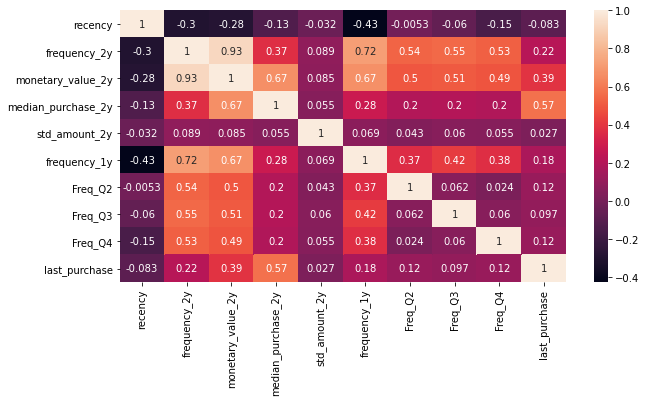

In [378]:
plt.figure(figsize=(10,5))
sns.heatmap(df_rfm.corr(),annot=True)
plt.show()

## **Calculating response rate**

In [379]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


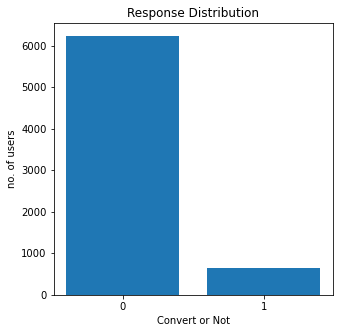

In [380]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

In [381]:
## merging two data sets

df_modeling1 = pd.merge(df_response,df_rfm)
df_modeling = pd.merge(df_modeling1,df_tbp)
df_modeling['Freq_Q2'] = df_modeling['Freq_Q2']/df_modeling['frequency_2y']
df_modeling['Freq_Q3'] = df_modeling['Freq_Q3']/df_modeling['frequency_2y']
df_modeling['Freq_Q4'] = df_modeling['Freq_Q4']/df_modeling['frequency_2y']
df_modeling['last_purchase'] = df_modeling['last_purchase']/df_modeling['monetary_value_2y']
df_modeling.head()

,customer_id,response,recency,frequency_2y,monetary_value_2y,median_purchase_2y,std_amount_2y,frequency_1y,Freq_Q2,Freq_Q3,Freq_Q4,last_purchase,days_between_trans
0,CS1112,0,62.0,6,358,59.666667,20.235283,4,0.166667,0.333333,0.333333,0.108939,93.500000
1,CS1113,0,36.0,11,775,70.454545,23.888757,6,0.363636,0.272727,0.000000,0.227097,71.263158
2,CS1114,1,33.0,11,804,73.090909,24.010225,5,0.090909,0.272727,0.363636,0.098259,72.722222
3,CS1115,1,12.0,11,831,75.545455,15.577956,3,0.363636,0.090909,0.181818,0.066185,62.047619
4,CS1116,1,204.0,5,333,66.600000,25.234896,4,0.400000,0.200000,0.000000,0.270270,96.250000


<AxesSubplot:>

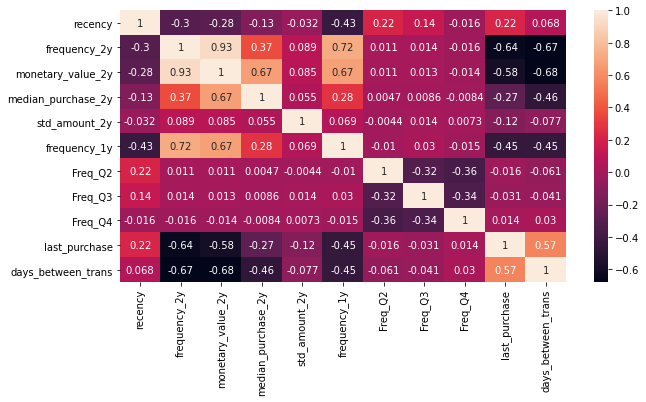

In [382]:
plt.figure(figsize=(10,5))
sns.heatmap(df_modeling.drop('response',axis=1).corr(),annot=True)

In [383]:
#df_modeling.drop(['median_purchase_2y','frequency_2y'],axis=1,inplace=True)

In [384]:
df_modeling.shape

(6781, 13)

## **Creating train and test dataset**

In [385]:
## spliting dataframe into X and y

X = df_modeling.drop(columns=['response','customer_id'])
y = df_modeling['response']

In [386]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (4746, 11)
Number transactions y_train dataset:  (4746,)
Number transactions X_test dataset:  (2035, 11)
Number transactions y_test dataset:  (2035,)


Text(0.5, 1.0, 'Imbalanced Data')

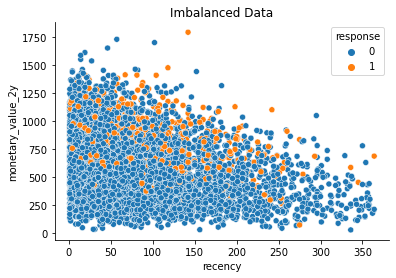

In [387]:
sns.scatterplot(data=df_modeling, x='recency', y='monetary_value_2y', hue='response')
sns.despine()
plt.title("Imbalanced Data")

## **Fixing imbalanced with Undersampling**

Text(0.5, 1.0, 'Undersampled Data')

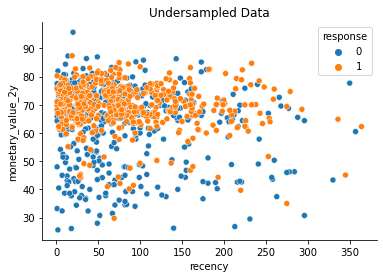

In [388]:
rus = RandomUnderSampler(random_state=0)
rus.fit(X_train, y_train)
X_undersampled, y_undersampled = rus.fit_resample(X_train, y_train)
df_undersampled = pd.concat([pd.DataFrame(data=X_undersampled),pd.DataFrame(data=y_undersampled)], axis=1, sort=False)
df_undersampled.columns= ['recency','median_purchase_2y','frequency_2y','monetary_value_2y','std_amount_2y','frequency_1y', 'Freq_Q2', 'Freq_Q3', 'Freq_Q4','last_purchase','days_between_trans', 'response']

sns.scatterplot(data=df_undersampled, x='recency', y='monetary_value_2y', hue='response')
sns.despine()
plt.title("Undersampled Data")

## **Fixing imbalanced with Oversampling**

Text(0.5, 1.0, 'Oversampled Data')

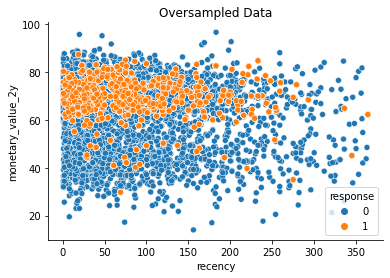

In [389]:
ros = RandomOverSampler(random_state=0)
ros.fit(X_train, y_train)
X_oversampled, y_oversampled = ros.fit_resample(X_train, y_train)
df_oversampled = pd.concat([pd.DataFrame(data=X_oversampled),pd.DataFrame(data=y_oversampled)], axis=1, sort=False)
df_oversampled.columns= ['recency','median_purchase_2y','frequency_2y', 'monetary_value_2y','std_amount_2y','frequency_1y', 'Freq_Q2', 'Freq_Q3', 'Freq_Q4','last_purchase','days_between_trans', 'response']

sns.scatterplot(data=df_oversampled, x='recency', y='monetary_value_2y', hue='response')
sns.despine()
plt.title("Oversampled Data")

## **Fixing imbalanced with SMOTE**

Text(0.5, 1.0, 'SMOTE Data')

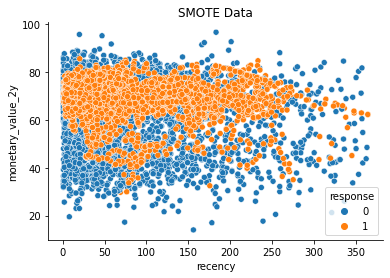

In [390]:
sm = SMOTE(random_state=0)
sm.fit(X_train, y_train)
X_SMOTE, y_SMOTE = sm.fit_resample(X_train, y_train)
df_SMOTE = pd.concat([pd.DataFrame(data=X_SMOTE),pd.DataFrame(data=y_SMOTE)], axis=1, sort=False)
df_SMOTE.columns= ['recency','median_purchase_2y','frequency_2y', 'monetary_value_2y','std_amount_2y','frequency_1y','Freq_Q2', 'Freq_Q3', 'Freq_Q4','last_purchase','days_between_trans', 'response']

sns.scatterplot(data=df_SMOTE, x='recency', y='monetary_value_2y', hue='response')
sns.despine()
plt.title("SMOTE Data")

## **Logistic Regression Model**

In [391]:
print('logistic regression model - undersampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')

predicted_y = []
expected_y = []

logreg_model_under = logreg.fit(X_undersampled, y_undersampled)
predictions = logreg_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_under.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - undersampled
training set
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       454
           1       0.71      0.76      0.73       454

    accuracy                           0.72       908
   macro avg       0.72      0.72      0.72       908
weighted avg       0.72      0.72      0.72       908

test set
              precision    recall  f1-score   support

           0       0.97      0.68      0.80      1844
           1       0.20      0.76      0.32       191

    accuracy                           0.69      2035
   macro avg       0.58      0.72      0.56      2035
weighted avg       0.89      0.69      0.76      2035



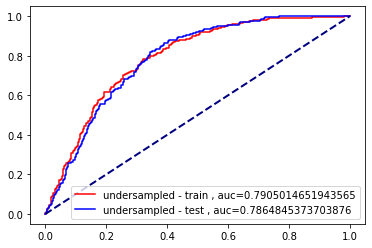

In [392]:
y_score_train = logreg_model_under.decision_function(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train)
auc_train = roc_auc_score(y_undersampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = logreg_model_under.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [393]:
print(logreg_model_under.coef_, logreg_model_under.intercept_)

[[ 0.00711182 -0.08259123  0.00554684 -0.0208     -0.00230374  0.01441687
  -0.63860962  0.2547382  -0.27542384 -0.66960769 -0.0078253 ]] [-1.55303652]


In [394]:
print('logistic regression model - oversampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_over = logreg.fit(X_oversampled, y_oversampled)
predictions = logreg_model_over.predict(X_oversampled)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_over.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - oversampled
training set
              precision    recall  f1-score   support

           0       0.75      0.69      0.72      4292
           1       0.71      0.76      0.74      4292

    accuracy                           0.73      8584
   macro avg       0.73      0.73      0.73      8584
weighted avg       0.73      0.73      0.73      8584

test set
              precision    recall  f1-score   support

           0       0.97      0.68      0.80      1844
           1       0.20      0.77      0.32       191

    accuracy                           0.69      2035
   macro avg       0.58      0.72      0.56      2035
weighted avg       0.89      0.69      0.75      2035



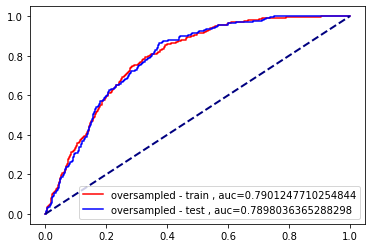

In [395]:
y_score_train = logreg_model_over.decision_function(X_oversampled)
fpr_train, tpr_train, _ = roc_curve(y_oversampled,  y_score_train)
auc_train = roc_auc_score(y_oversampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='oversampled - train , auc='+str(auc_train))

y_score_test = logreg_model_over.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='oversampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [396]:
print(logreg_model_over.coef_, logreg_model_under.intercept_)

[[ 0.00801624  0.09119007  0.00262807  0.00598855 -0.0056957   0.04328408
  -0.33797706  0.06634968 -0.17604563 -1.67410116 -0.00817232]] [-1.55303652]


In [397]:
print('logistic regression model - SMOTE')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE = logreg.fit(X_SMOTE, y_SMOTE)
predictions = logreg_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE
training set
              precision    recall  f1-score   support

           0       0.76      0.73      0.74      4292
           1       0.74      0.77      0.75      4292

    accuracy                           0.75      8584
   macro avg       0.75      0.75      0.75      8584
weighted avg       0.75      0.75      0.75      8584

test set
              precision    recall  f1-score   support

           0       0.95      0.71      0.82      1844
           1       0.19      0.66      0.30       191

    accuracy                           0.71      2035
   macro avg       0.57      0.69      0.56      2035
weighted avg       0.88      0.71      0.77      2035



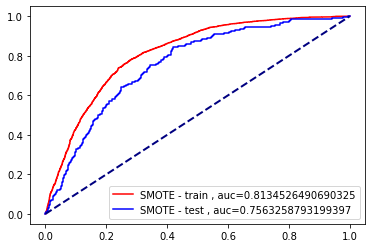

In [398]:
y_score_train = logreg_model_SMOTE.decision_function(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train)
auc_train = roc_auc_score(y_SMOTE, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = logreg_model_SMOTE.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [399]:
print(logreg_model_SMOTE.coef_, logreg_model_under.intercept_)

[[ 0.00597018 -0.82451974  0.01600147 -0.10297927  0.02297524 -0.06555127
   0.88718008  1.39488526  1.04869397 -2.6202287  -0.01180904]] [-1.55303652]


## **XGBoost**

In [400]:
print('XGBoost model - undersampled')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_under = xgb_model.fit(X_undersampled, y_undersampled, early_stopping_rounds=5, eval_set=[(X_test, y_test)])
predictions =  xgb_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_under.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - undersampled
[0]	validation_0-auc:0.774768
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.801199
[2]	validation_0-auc:0.798414
[3]	validation_0-auc:0.796443
[4]	validation_0-auc:0.799662
[5]	validation_0-auc:0.798708
[6]	validation_0-auc:0.798488
Stopping. Best iteration:
[1]	validation_0-auc:0.801199

training set
              precision    recall  f1-score   support

           0       0.79      0.65      0.71       454
           1       0.70      0.83      0.76       454

    accuracy                           0.74       908
   macro avg       0.75      0.74      0.74       908
weighted avg       0.75      0.74      0.74       908

test set
              precision    recall  f1-score   support

           0       0.97      0.62      0.76      1844
           1       0.19      0.83      0.30       191

    accuracy                           0.64      2035
   macro avg       0.58      0.73      0.53      2035
weighted avg       0

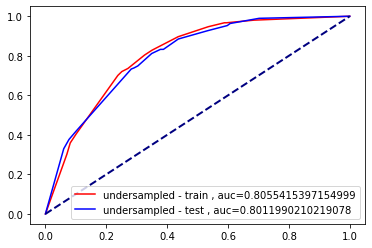

In [401]:
y_score_train = xgb_model_under.predict_proba(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train[:,1])
auc_train = roc_auc_score(y_undersampled, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = xgb_model_under.predict_proba(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

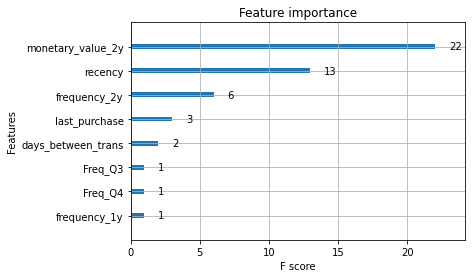

In [402]:
xgb.plot_importance(xgb_model_under)

In [403]:
print('XGBoost model - oversampled')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_over = xgb_model.fit(X_oversampled, y_oversampled, early_stopping_rounds=5, eval_set=[(X_test, y_test)])
predictions =  xgb_model_over.predict(X_oversampled)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_over.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - oversampled
[0]	validation_0-auc:0.787109
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.788073
[2]	validation_0-auc:0.79106
[3]	validation_0-auc:0.798712
[4]	validation_0-auc:0.801428
[5]	validation_0-auc:0.804
[6]	validation_0-auc:0.803591
[7]	validation_0-auc:0.803908
[8]	validation_0-auc:0.803533
[9]	validation_0-auc:0.804429
[10]	validation_0-auc:0.805743
[11]	validation_0-auc:0.80641
[12]	validation_0-auc:0.807888
[13]	validation_0-auc:0.806199
[14]	validation_0-auc:0.806545
[15]	validation_0-auc:0.80652
[16]	validation_0-auc:0.80532
[17]	validation_0-auc:0.804172
Stopping. Best iteration:
[12]	validation_0-auc:0.807888

training set
              precision    recall  f1-score   support

           0       0.81      0.66      0.72      4292
           1       0.71      0.84      0.77      4292

    accuracy                           0.75      8584
   macro avg       0.76      0.75      0.75      8584
weighted avg       0.76  

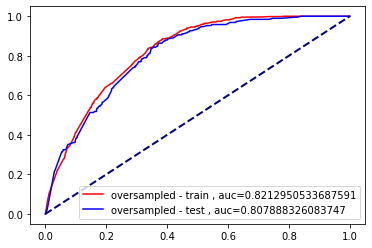

In [404]:
y_score_train = xgb_model_over.predict_proba(X_oversampled)
fpr_train, tpr_train, _ = roc_curve(y_oversampled,  y_score_train[:,1])
auc_train = roc_auc_score(y_oversampled, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='oversampled - train , auc='+str(auc_train))

y_score_test = xgb_model_over.predict_proba(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='oversampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

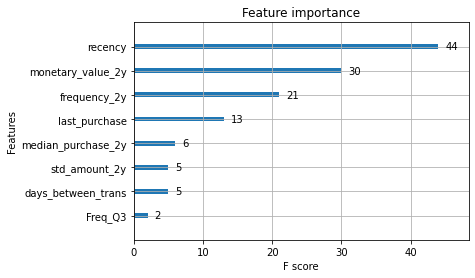

In [405]:
xgb.plot_importance(xgb_model_over)

In [406]:
print('XGBoost model - SMOTE')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_SMOTE = xgb_model.fit(X_SMOTE, y_SMOTE, early_stopping_rounds=5, eval_set=[(X_test, y_test)])
predictions =  xgb_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE
[0]	validation_0-auc:0.772037
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.778428
[2]	validation_0-auc:0.778678
[3]	validation_0-auc:0.789517
[4]	validation_0-auc:0.793459
[5]	validation_0-auc:0.787451
[6]	validation_0-auc:0.791103
[7]	validation_0-auc:0.792482
[8]	validation_0-auc:0.788861
[9]	validation_0-auc:0.78835
Stopping. Best iteration:
[4]	validation_0-auc:0.793459

training set
              precision    recall  f1-score   support

           0       0.82      0.64      0.72      4292
           1       0.70      0.85      0.77      4292

    accuracy                           0.75      8584
   macro avg       0.76      0.75      0.74      8584
weighted avg       0.76      0.75      0.74      8584

test set
              precision    recall  f1-score   support

           0       0.97      0.63      0.76      1844
           1       0.19      0.84      0.31       191

    accuracy                           0.65   

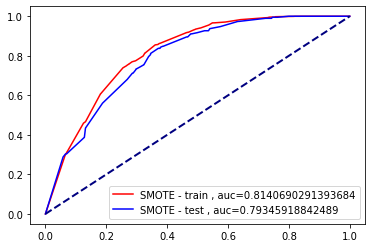

In [407]:
y_score_train = xgb_model_SMOTE.predict_proba(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = xgb_model_SMOTE.predict_proba(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

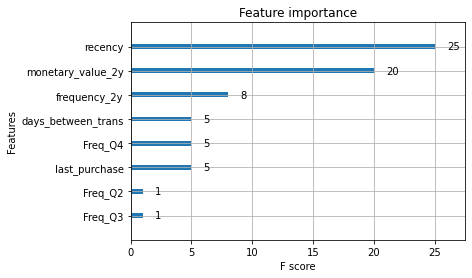

In [408]:
xgb.plot_importance(xgb_model_SMOTE)

In [409]:
print('XGBoost model - SMOTE - parameter tuning')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc",
 base_score=0.5,
 learning_rate =0.30,
 n_estimators=3000,
 max_depth=3,
 min_child_weight=2,
 gamma=0.3,
 subsample=0.3,
 colsample_bytree=0.4,
 nthread=4)
predicted_y = []
expected_y = []

xgb_model_SMOTE_tuned = xgb_model.fit(X_SMOTE, y_SMOTE, early_stopping_rounds=5, eval_set=[(X_test, y_test)])
predictions =  xgb_model_SMOTE_tuned.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_tuned.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE - parameter tuning
[0]	validation_0-auc:0.773295
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.796582
[2]	validation_0-auc:0.791624
[3]	validation_0-auc:0.78886
[4]	validation_0-auc:0.786218
[5]	validation_0-auc:0.785868
[6]	validation_0-auc:0.78679
Stopping. Best iteration:
[1]	validation_0-auc:0.796582

training set
              precision    recall  f1-score   support

           0       0.81      0.63      0.70      4292
           1       0.69      0.85      0.76      4292

    accuracy                           0.74      8584
   macro avg       0.75      0.74      0.73      8584
weighted avg       0.75      0.74      0.73      8584

test set
              precision    recall  f1-score   support

           0       0.97      0.62      0.76      1844
           1       0.18      0.83      0.30       191

    accuracy                           0.64      2035
   macro avg       0.58      0.72      0.53      2035
weighted a

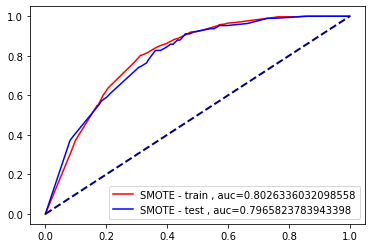

In [410]:
y_score_train = xgb_model_SMOTE_tuned.predict_proba(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = xgb_model_SMOTE_tuned.predict_proba(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()